In [1]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM
from py4DSTEM.file.datastructure import DataCube, DiffractionSlice, RealSlice, PointList, PointListArray
from py4DSTEM.file.datastructure import DataObject


from py4DSTEM.process.calibration import get_probe_size
from py4DSTEM.process.dpc import get_CoM_images, get_phase_from_CoM
from py4DSTEM.process.dpc import get_wavenumber, get_interaction_constant

from matplotlib.patches import Circle

from scipy import ndimage
from scipy.spatial import distance


from skimage import filters
from skimage.morphology import disk

%matplotlib notebook

In [3]:
fp3 = "C:/Users/Roberto/Desktop/data_enamel/enamel_combo_large_3p5mrad.h5"

In [5]:
dc3 = py4DSTEM.file.io.read(fp3)

C:/Users/Roberto/Desktop/data_enamel/enamel_combo_large_3p5mrad.h5 is a py4DSTEM file, v0.5. Reading...


In [6]:
DataObject.get_dataobjects()

In [7]:
DataObject.sort_dataobjects_by_type(show=True)

 Index                  Name                        Type        
   0    CBED_array_depth0000                DataCube            
   1    CBED_array_depth0000                DataCube            


In [8]:
ar3 = DataObject.get_dataobject_by_index(0)

In [9]:
# ar00.data.shape, ar02.data.shape,ar010.data.shape

<IPython.core.display.Javascript object>


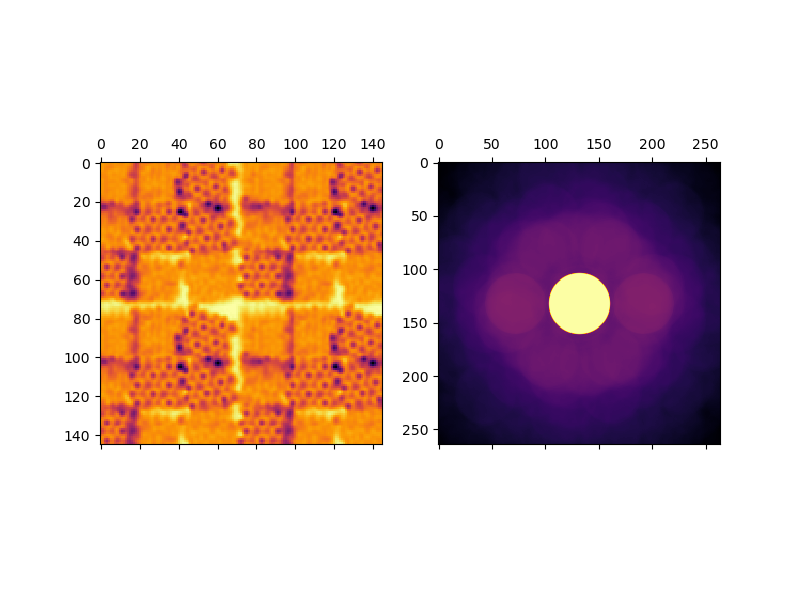

In [10]:
power = 0.02

BF = np.average(ar3.data,axis=(2,3))
aveDP = np.average(ar3.data,axis=(0,1))

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,6))
ax1.matshow(BF, cmap="inferno")
ax2.matshow(np.log10(abs(aveDP)), cmap="inferno")

plt.savefig("sim_3_5mrad.png")
plt.show()

<IPython.core.display.Javascript object>


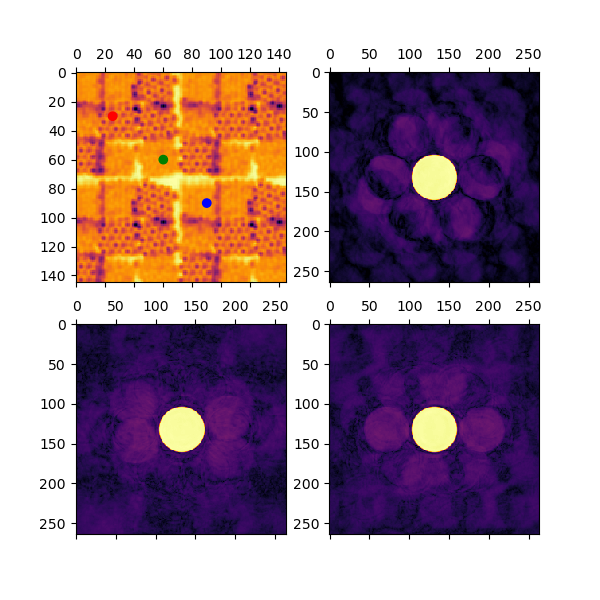

In [11]:
# Select scan positions
Rxs=(30,60,90)
Rys=(25,60,90)
power = 0.2

# Show
fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(6,6))
ax11.matshow(BF, cmap="inferno")
ax11.scatter(Rys,Rxs,color=('r','g','b'))
ax12.matshow(ar3.data[Rxs[0],Rys[0],:,:]**power, cmap="inferno", vmin = 0.02)
ax21.matshow(ar3.data[Rxs[1],Rys[1],:,:]**power, cmap="inferno")
ax22.matshow(ar3.data[Rxs[2],Rys[2],:,:]**power, cmap="inferno")

# plt.savefig("sim_3_5mrad_combo.png")
plt.show()

In [12]:
from skimage import feature
blob=feature.blob_log(aveDP, threshold = 0.0001)
ic=blob[0,0]
jc=blob[0,1]
print("ic is " + str(ic))
print("jc is " + str(jc))


ic is 132.0
jc is 132.0


<IPython.core.display.Javascript object>


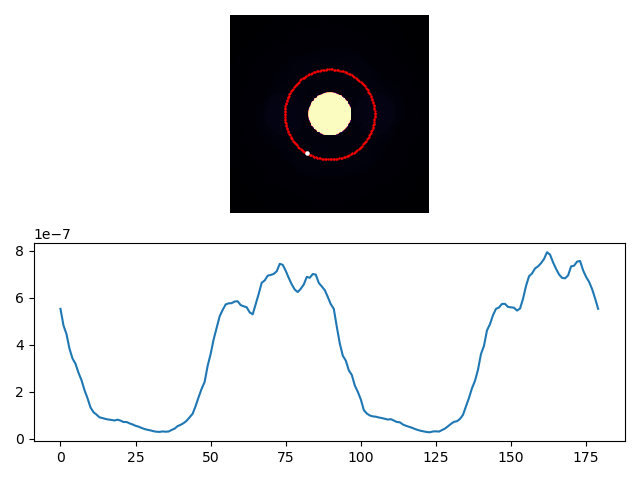

In [13]:
pixel_rad=60
image=ar3.data[60,60,:,:]

n_dots = 180   # set number of dots
angs = np.linspace(0, 2*np.pi, n_dots)+2.1  # angles to the dots
cx, cy = (jc, ic)  # center of circle
xs, ys = [], []    # for coordinates of points to plot
ra = pixel_rad          # radius of circle

for ang in angs:
    # compute (x,y) for each point
    x = cx + ra*np.cos(ang)
    y = cy + ra*np.sin(ang)
    xs.append(x)   # collect x
    ys.append(y)   # collect y

xs=np.asarray(xs)
ys=np.asarray(ys)

zi=np.zeros((1,len(xs)))
for ii in range(0,len(xs)):
    zi[0,ii] = np.average(image[xs[ii].astype(np.int)-10:xs[ii].astype(np.int)+10, \
                               ys[ii].astype(np.int)-10:ys[ii].astype(np.int)+10])
    

fig, axes = plt.subplots(nrows=2)

axes[0].scatter(xs, ys, c = 'red', s=0.5)  # plot points 
axes[0].scatter(cx + ra*np.cos(2.1), cy + ra*np.sin(2.1), c = 'white', s=5)  # plot points 
axes[0].imshow(np.sqrt(aveDP), cmap= plt.cm.magma)
axes[0].axis('off')

axes[1].plot(zi[0,:])
fig.tight_layout()
plt.show()

In [14]:
peak_max=np.zeros((ar3.data.shape[0],ar3.data.shape[1]))
remain=np.zeros((ar3.data.shape[0],ar3.data.shape[1]))

n_dots = 180   # set number of dots
angs = np.linspace(0, 2*np.pi, n_dots)  # angles to the dots
cx, cy = (jc, ic)  # center of circle
ra = pixel_rad 


for i in range(0,ar3.data.shape[0]):
        for j in range(0,ar3.data.shape[1]): 
            image=ar3.data[i,j,:,:]
            xs, ys = [], []    
      

            for ang in angs:
                x = cx + ra*np.cos(ang)
                y = cy + ra*np.sin(ang)
                xs.append(x)   
                ys.append(y)   

            xs=np.asarray(xs)
            ys=np.asarray(ys)

            zi=np.zeros((1,len(xs)))
            for ii in range(0,len(xs)):
                    zi[0,ii] = np.average(image[xs[ii].astype(np.int)-10:xs[ii].astype(np.int)+10, \
                               ys[ii].astype(np.int)-10:ys[ii].astype(np.int)+10])
            
            max_loc=np.argmax(zi)
            peak_max[i,j]=max_loc
            remain[i,j]=max_loc%90


<IPython.core.display.Javascript object>


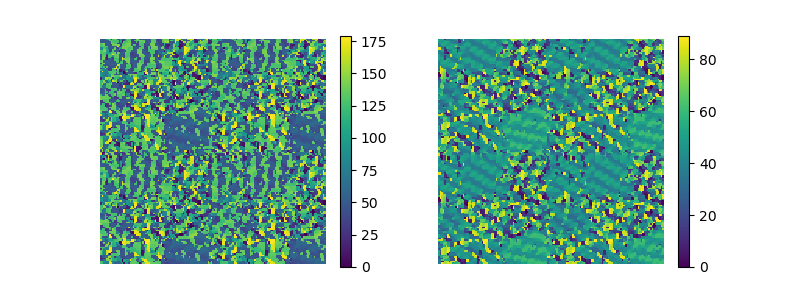

In [15]:
fig,axs = plt.subplots(1,2,figsize=(8,3))
map0=axs[0].imshow(peak_max, cmap=plt.cm.viridis)  
fig.colorbar(map0, ax=axs[0])

map1=axs[1].imshow(remain, cmap=plt.cm.viridis)  
fig.colorbar(map1)

axs[0].axis('off')
axs[1].axis('off')

plt.show()

In [23]:
xa, ya = 80, 165 

#rotate point by 60° relative to ic, jc (going to use point-point form to define lines for masks)
theta = np.radians(60)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

v=np.array([[xa-jc],[ya-ic]])
v=np.dot(v.T,R).T
xb=v[0,0]+jc
yb=v[1,0]+ic

v=np.dot(v.T,R).T
xc=v[0,0]+jc
yc=v[1,0]+ic

masks=[]

#radii=[30,50,70,90]
radii=[35] #mask start radii in pixels
width=80 #mask width in pixels
#create masks changing inequalities
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))

for aa in radii: 
    mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < (aa+width) ** 2
    mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > aa ** 2
    mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
    mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) > 0
    mask1 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
    masks.append(mask1)
    mask1_COM_1=ndimage.measurements.center_of_mass(mask1)
    
    mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < (aa+width) ** 2
    mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > aa ** 2
    mask_line =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
    mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) < 0
    mask2= np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
    masks.append(mask2)
    mask2_COM_1=ndimage.measurements.center_of_mass(mask2)


    mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < (aa+width) ** 2
    mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > aa ** 2
    mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
    mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
    mask3 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
    masks.append(mask3)
    mask3_COM_1=ndimage.measurements.center_of_mass(mask3)


    mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < (aa+width) ** 2
    mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > aa ** 2
    mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
    mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) < 0
    mask4 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
    masks.append(mask4)
    mask4_COM_1=ndimage.measurements.center_of_mass(mask4)

    mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < (aa+width) ** 2
    mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > aa ** 2
    mask_line =  y - xc - (jc-xc)/(ic-yc) * (x-yc) > 0
    mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
    mask5= np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
    masks.append(mask5)
    mask5_COM_1=ndimage.measurements.center_of_mass(mask5)
    
    mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < (aa+width) ** 2
    mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > aa ** 2
    mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
    mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
    mask6 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
    masks.append(mask6)
    mask6_COM_1=ndimage.measurements.center_of_mass(mask6)
    

In [24]:
color_maps=[]
int_mask=np.zeros((ar3.data.shape[0],ar3.data.shape[1]))

for k in range(6*len(radii)):
    int_mask=np.zeros((ar3.data.shape[0],ar3.data.shape[1]))
    for i in range(0,aveDP.shape[0]):
        for j in range(0,aveDP.shape[1]): 
            if masks[k][i,j]:
                int_mask=int_mask+ar3.data[:,:,i,j] 
    #int_mask=int_mask/masks_12[k].sum()
    color_maps.append(int_mask)

In [25]:
int_mask=np.zeros((ar3.data.shape[2],ar3.data.shape[3]))
int_mask.shape

(264, 264)

<IPython.core.display.Javascript object>


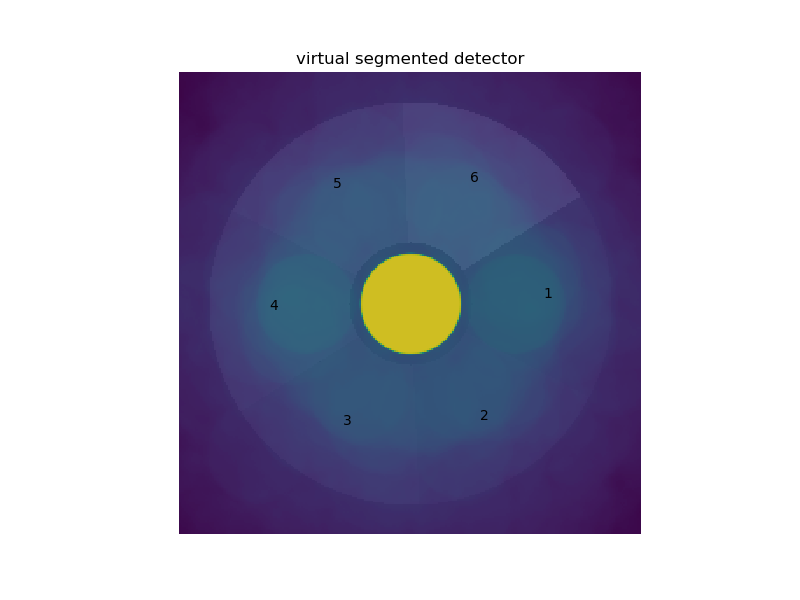

number of elements in mask1 is 6282
number of elements in mask2 is 6281
number of elements in mask3 is 6276
number of elements in mask4 is 6282
number of elements in mask5 is 6281
number of elements in mask6 is 6276


In [27]:
#plot masks
fig,ax = plt.subplots(figsize=(8,6))

ax.imshow(mask1, alpha=0.3)
ax.text(mask1_COM_1[1],mask1_COM_1[0], '1', ha='center')
ax.imshow(mask2, alpha=0.3)
ax.text(mask2_COM_1[1],mask2_COM_1[0],'2', ha='center')
ax.imshow(mask3, alpha=0.3)
ax.text(mask3_COM_1[1],mask3_COM_1[0],'3', ha='center')
ax.imshow(mask4, alpha=0.3)
ax.text(mask4_COM_1[1],mask4_COM_1[0],'4', ha='center')
ax.imshow(mask5, alpha=0.3)
ax.text(mask5_COM_1[1],mask5_COM_1[0],'5', ha='center')
ax.imshow(mask6, alpha=0.3)
ax.text(mask6_COM_1[1],mask6_COM_1[0],'6', ha='center')
ax.imshow(np.log10(aveDP), cmap=plt.cm.viridis, alpha=0.8)
ax.set_title('virtual segmented detector')
ax.axis('off')

plt.savefig('masked_simulated_CBED.png')
plt.show()

#check they are of equal area
print('number of elements in mask1 is ' + str(mask1.sum()))
print('number of elements in mask2 is ' + str(mask2.sum()))
print('number of elements in mask3 is ' + str(mask3.sum()))
print('number of elements in mask4 is ' + str(mask4.sum()))
print('number of elements in mask5 is ' + str(mask5.sum()))
print('number of elements in mask6 is ' + str(mask6.sum()))

In [28]:
num=np.linspace(0,6*len(radii)-1,6*len(radii))
for numbers in num:
  print(f"Mask {int(numbers)} max is {np.min(color_maps[int(numbers)])}")
   # print(f"Mask {int(numbers)} min is {np.min(color_maps[int(numbers)])}")

Mask 0 max is 0.00012998910488138185
Mask 1 max is 0.00011141449513051623
Mask 2 max is 0.00011043183905994126
Mask 3 max is 0.000131554969351737
Mask 4 max is 0.00011235667640514547
Mask 5 max is 0.00011476338237983975


<IPython.core.display.Javascript object>


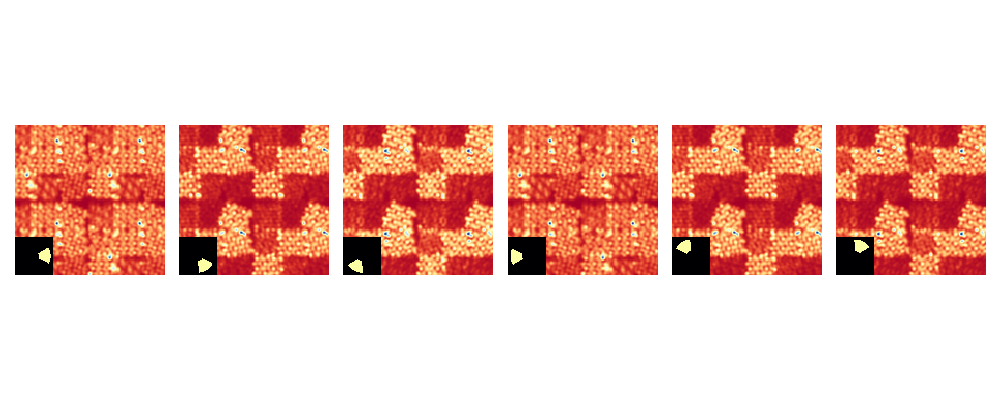

In [29]:
fig, axes = plt.subplots(len(radii),6, figsize=(10,4))
for ax, numbers in zip(axes.flatten(), num):
    ax.imshow(color_maps[int(numbers)], cmap=plt.cm.RdYlBu)
    ins = ax.inset_axes([0,0,0.25,0.25])
    ins.imshow(masks[int(numbers)], cmap=plt.cm.inferno)
    ax.axis('off')
    ins.axis('off')
plt.tight_layout()
plt.savefig('test_detectors.png')
plt.show()

<IPython.core.display.Javascript object>


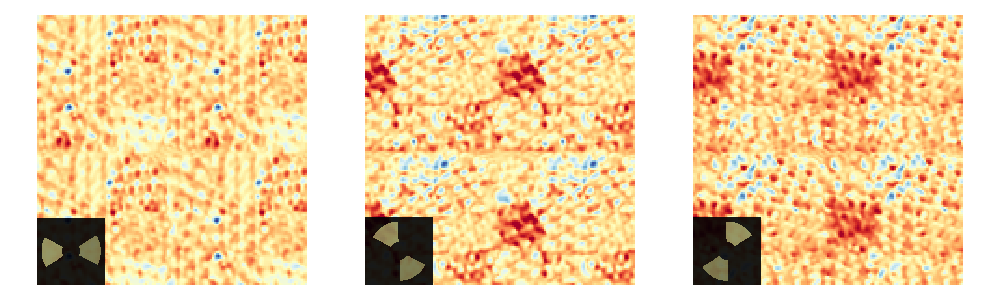

0.1963600393819745
0.18199094552145664
0.1541465428369157


In [36]:
num=np.array([0,1,2])
fig, axes = plt.subplots(1,3, figsize=(10,3))
for ax, numbers in zip(axes.flatten(), num):
    ax.imshow((color_maps[int(numbers)]-color_maps[int(numbers+3)])/
                       (color_maps[int(numbers)]+color_maps[int(numbers+3)]), cmap=plt.cm.RdYlBu, vmin = -0.13, vmax = 0.196)
    print(np.max((color_maps[int(numbers)]-color_maps[int(numbers+3)])/
                     (color_maps[int(numbers)]+color_maps[int(numbers+3)])))
    ins = ax.inset_axes([0,0,0.25,0.25])
    ins.imshow(masks[int(numbers)], cmap=plt.cm.inferno, alpha=0.8)
    ins.imshow(masks[int(numbers + 3)], cmap=plt.cm.inferno, alpha=0.5)
    ax.axis('off')
    ins.axis('off')
plt.tight_layout()
plt.show()

In [37]:
def rescale_linear(array, new_min, new_max):
    """Rescale an arrary linearly."""
    minimum, maximum = np.min(array), np.max(array)
    m = (new_max - new_min) / (maximum - minimum)
    b = new_min - m * minimum
    return m * array + b

In [33]:
#calculate Beta

location_difference=np.zeros((ar3.data.shape[0],ar3.data.shape[1]))
for i in range(0,ar3.data.shape[0]):
        for j in range(0,ar3.data.shape[1]):
            filtered_data=filters.median(rescale_linear(ar3.data[i,j,:,:],0,1), disk(2))
            
            max1=np.unravel_index(np.ma.array(filtered_data, mask=~mask1).argmax(), filtered_data.shape)
            max2=np.unravel_index(np.ma.array(filtered_data, mask=~mask2).argmax(), filtered_data.shape)
            max3=np.unravel_index(np.ma.array(filtered_data, mask=~mask3).argmax(), filtered_data.shape)
            max4=np.unravel_index(np.ma.array(filtered_data, mask=~mask4).argmax(), filtered_data.shape)
            max5=np.unravel_index(np.ma.array(filtered_data, mask=~mask5).argmax(), filtered_data.shape)
            max6=np.unravel_index(np.ma.array(filtered_data, mask=~mask6).argmax(), filtered_data.shape)
            max1_value=np.sum(np.ma.array(filtered_data, mask=~mask1))
            max2_value=np.sum(np.ma.array(filtered_data, mask=~mask2))
            max3_value=np.sum(np.ma.array(filtered_data, mask=~mask3))
            max4_value=np.sum(np.ma.array(filtered_data, mask=~mask4))
            max5_value=np.sum(np.ma.array(filtered_data, mask=~mask5))
            max6_value=np.sum(np.ma.array(filtered_data, mask=~mask6))         
            if max1_value >= max2_value and max1_value >= max3_value and max1_value >= max4_value and \
            max1_value >= max5_value and max1_value >= max6_value:
                ind1=max1
                ind2=max4
            if max2_value >= max1_value and max2_value >= max3_value and max2_value >= max4_value and \
            max2_value >= max5_value and max2_value >= max6_value:
                ind1=max2
                ind2=max5    
            if max3_value >= max2_value and max3_value >= max1_value and max3_value >= max4_value and \
            max3_value >= max5_value and max3_value >= max6_value:
                ind1=max3
                ind2=max6 
            if max4_value >= max2_value and max4_value >= max3_value and max4_value >= max1_value and \
            max4_value >= max5_value and max4_value >= max6_value:
                ind1=max4
                ind2=max1
            if max5_value >= max2_value and max5_value >= max3_value and max5_value >= max4_value and \
            max5_value >= max1_value and max5_value >= max6_value:
                ind1=max5
                ind2=max2
            if max6_value >= max2_value and max6_value >= max3_value and max6_value >= max6_value and \
            max6_value >= max5_value and max6_value >= max1_value:
                ind1=max6
                ind2=max1
            location_difference[i,j]=distance.euclidean(ind1,[jc,ic])-distance.euclidean(ind2,[jc,ic])


<IPython.core.display.Javascript object>


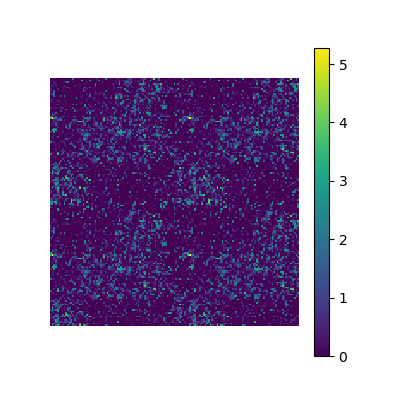

In [39]:
fig,ax = plt.subplots(figsize=(4,4))
image=ax.imshow(np.abs(location_difference/25*3.5/2), cmap=plt.cm.viridis) #22/3.5 to normalize for mrad, approximate center disk as 2 mrad
fig.colorbar(image, ax=ax)
ax.axis('off')
plt.show()

In [45]:
import math

strain_matrix=np.zeros([ar3.data.shape[0],ar3.data.shape[1],3,3])
local_alpha=rescale_linear(filters.median(rescale_linear(remain,0,1), disk(2)),0,math.pi)
remain=rescale_linear(remain,0,math.pi)

for i in range(0,ar3.data.shape[0]):
        for j in range(0,ar3.data.shape[1]):
            xy_matrix=[[math.cos(remain[i,j]-local_alpha[i,j]), math.sin(remain[i,j]-local_alpha[i,j]), 0],
                      [math.sin(remain[i,j]-local_alpha[i,j]), math.cos(remain[i,j]-local_alpha[i,j]),0],
                        [0,0,1]]
            xz_matrix=[[math.cos(location_difference[i,j]/25*3.5/1000/2), 0, math.sin(location_difference[i,j]/25*3.5/1000/2)],
                      [0, 1, 0],
                      [math.sin(location_difference[i,j]/25*3.5/1000/2), 0, math.cos(location_difference[i,j]/25*3.5/1000/2)]]
            yz_matrix=[[1, 0, 0],
                       [0, math.cos(location_difference[i,j]/25*3.5/1000/2), math.sin(location_difference[i,j]/25*3.5/1000/2)], 
                       [0, math.sin(location_difference[i,j]/25*3.5/1000/2), math.cos(location_difference[i,j]/25*3.5/1000/2)]]
            strain_matrix[i,j,:,:]=np.dot(np.dot(xy_matrix,xz_matrix),yz_matrix)

<IPython.core.display.Javascript object>


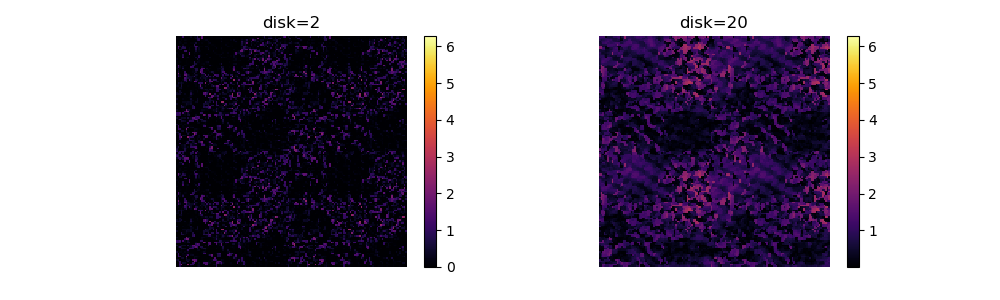

In [46]:
fig,axs = plt.subplots(1,2,figsize=(10,3))

local_alpha=rescale_linear(filters.median(rescale_linear(remain,0,1), disk(2)),0,math.pi)

map0=axs[0].imshow(np.abs(remain-local_alpha), cmap=plt.cm.inferno, vmax=2*math.pi)  
fig.colorbar(map0, ax=axs[0])

local_alpha=rescale_linear(filters.rank.mean(rescale_linear(remain,0,1), disk(20)),0,math.pi)

map1=axs[1].imshow(np.abs(remain-local_alpha), cmap=plt.cm.inferno, vmax=2*math.pi)  
fig.colorbar(map1)

axs[0].axis('off')
axs[1].axis('off')

axs[0].set_title('disk=2')
axs[1].set_title('disk=20')

plt.show()

<IPython.core.display.Javascript object>


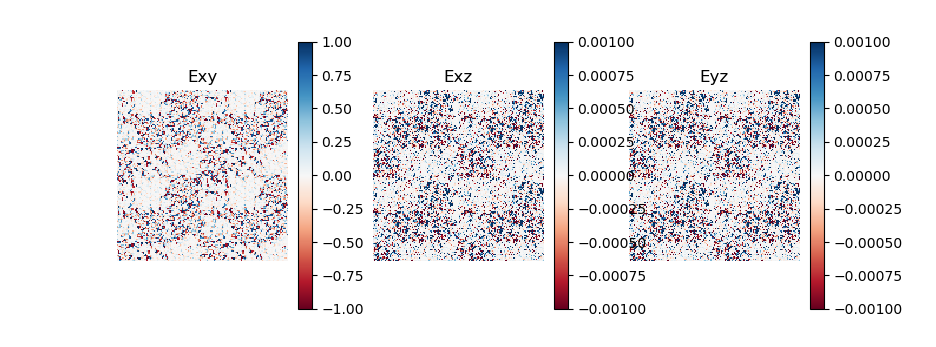

In [48]:
fig,ax = plt.subplots(1,3, figsize=(10,3))

image=ax[0].imshow(strain_matrix[:,:,0,1], cmap=plt.cm.RdBu, vmin=-1, vmax=1) 
fig.colorbar(image, ax=ax[0])
ax[0].axis('off')
ax[0].set_title('Exy')

image=ax[1].imshow(strain_matrix[:,:,0,2], cmap=plt.cm.RdBu, vmin = -1/1000, vmax=1/1000) 
fig.colorbar(image, ax=ax[1])
ax[1].axis('off')
ax[1].set_title('Exz')

image=ax[2].imshow(strain_matrix[:,:,1,2], cmap=plt.cm.RdBu, vmin=-1/1000, vmax=1/1000)
fig.colorbar(image, ax=ax[2])
ax[2].axis('off')
ax[2].set_title('Eyz')

plt.tight_layout

# plt.savefig('simulated_strain.png')
plt.show()

In [27]:
strain_matrix.shape

(145, 145, 3, 3)